In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure

In [2]:
def generate_small_blobs(length = 64, blob_size_fraction = 0.1,
                   n_dim = 2,
                   volume_fraction = 0.2, seed = None):
  rs = np.random.default_rng(seed)
  shape = tuple([length] * n_dim)
  mask = np.zeros(shape)
  n_pts = max(int(1. / blob_size_fraction) ** n_dim, 1)
  points = (length * rs.random((n_dim, n_pts))).astype(int)
  mask[tuple(indices for indices in points[:,:])] = 1

  mask = gaussian(mask, sigma=0.25 * length * blob_size_fraction,
                  preserve_range=False)

  threshold = np.percentile(mask, 100 * (1 - volume_fraction))
  return np.logical_not(mask < threshold)

In [3]:
def generate_big_blob(img_size = 64, avg_size = 10, random_size_range = 0):
  img = np.zeros((img_size, img_size))
  posx = np.random.randint(img_size)
  posy = np.random.randint(img_size)
  blob_size = np.random.randint(avg_size-random_size_range, avg_size+random_size_range+1)
  rr, cc = sk.draw.disk((posy, posx), blob_size, shape=(img_size, img_size))

  img[rr,cc] = 1
  return img


In [4]:
def generate_blob_img(big = True, length = 64, blob_size_fraction = 0.1,
                      n_dim = 2, volume_fraction = 0.3, seed = None,
                      big_blob_size = 10, big_blob_range=0):
  small_blobs = generate_small_blobs(length, blob_size_fraction, 
                                     n_dim, volume_fraction, seed) 
  if big:
    big_blob = generate_big_blob(length, big_blob_size, big_blob_range)
    return np.logical_or(small_blobs, big_blob)
  else:
    return small_blobs


In [5]:
from skimage.transform import rotate
def generate_small_blobs2(length = 64, blob_size_fraction = 0.1,
                   n_dim = 2,
                   volume_fraction = 0.2, seed = None, randomize_sigma = True, rotation = True):
  rs = np.random.default_rng(seed)
  shape = length
  n_pts = max(int(1. / blob_size_fraction) ** n_dim, 1)
  mask = np.zeros((shape, shape, n_pts))
  points = (length * rs.random((n_dim, n_pts))).astype(int)

  sigma_factor_x = 0.25
  sigma_factor_y = 0.25

  for i in range(n_pts):
    mask[points[:,i][0], points[:,i][1], i] = 1
    if randomize_sigma:
      sigma_factor_x = (np.random.randint(low = 10, high = 50)/100)
      sigma_factor_y = (np.random.randint(low = 10, high = 50)/100)

    mask[:,:,i] = gaussian(mask[:,:,i], sigma=[sigma_factor_x * length * blob_size_fraction, sigma_factor_y * length * blob_size_fraction],
                    preserve_range=False)
  
    angle = np.random.randint(low = 0, high = 180)
    if rotation:
      mask[:,:,i] = rotate(mask[:,:,i], angle)
  mask = mask.sum(axis = -1)

  threshold = np.percentile(mask, 100 * (1 - volume_fraction))
  return np.logical_not(mask < threshold)

In [572]:
def generate_big_blob2(img_size = 64, maj_axis=15, min_axis=5):
  img = np.zeros((img_size, img_size))
  #size_maj = np.random.randint(avg_size, avg_size+random_size_range+1)
  #size_min = np.random.randint(avg_size-random_size_range, avg_size)
  #posx = np.random.randint(np.max([size_min, size_maj]), img_size - np.max([size_maj, size_min]))
  #posy = np.random.randint(np.max([size_min, size_maj]), img_size - np.max([size_maj, size_min]))
  posx = np.random.randint(maj_axis, img_size-maj_axis)
  posy = np.random.randint(maj_axis, img_size-maj_axis)
  rr, cc = sk.draw.ellipse(posy, posx, maj_axis, min_axis, shape=(img_size, img_size), rotation=np.random.randint(-15, 15)/10)

  img[rr,cc] = 1
  return img


In [479]:
def generate_big_blobs(num_blobs = 1, img_size = 64, avg_size = 10, random_size_range = 0):
  img = np.zeros((img_size, img_size))
  for i in range(num_blobs):
    posx = np.random.randint(img_size)
    posy = np.random.randint(img_size)
    blob_size = np.random.randint(avg_size-random_size_range, avg_size+random_size_range+1)
    rr, cc = sk.draw.disk((posy, posx), blob_size, shape=(img_size, img_size))

    img[rr,cc] = 1
  return img

In [675]:
def generate_new_blob_img(ellipse = True, maj_axis = 17, min_axis = 5):
    r = np.floor(np.sqrt(maj_axis*min_axis))
    x = generate_big_blobs(num_blobs=7, img_size=128, avg_size=r , random_size_range=0)
    x2 = generate_small_blobs2(length = 128, blob_size_fraction = 0.06,
                      n_dim = 2, volume_fraction = 0.2, randomize_sigma = False, rotation= False)
    if ellipse:
        y = generate_big_blob2(128, maj_axis, min_axis)
        return np.logical_or(x,np.logical_or(x2,y)) 
    else:
        return np.logical_or(x, x2)


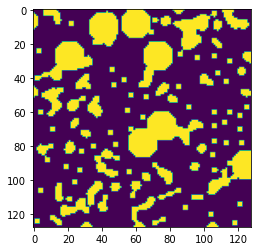

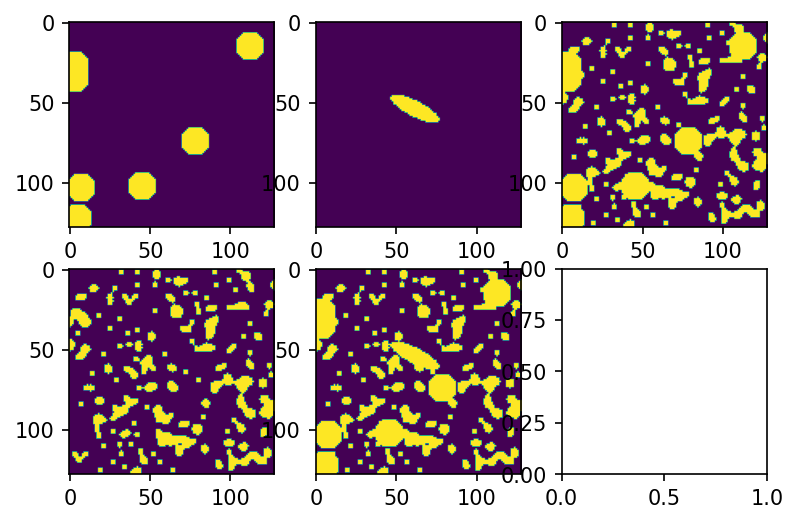

In [674]:
import skimage.morphology as morphology
from skimage.measure import regionprops_table, label
maj_axis = 17
min_axis = 5
r = np.floor(np.sqrt(maj_axis*min_axis))

x = generate_big_blobs(num_blobs=7, img_size=128, avg_size=r , random_size_range=0)
x2 = generate_small_blobs2(length = 128, blob_size_fraction = 0.06,
                      n_dim = 2, volume_fraction = 0.2, randomize_sigma = False, rotation= False)
y = generate_big_blob2(128, maj_axis, min_axis)
#plt.imshow(y)
#plt.imshow(x)
#plt.imshow(x2)
#plt.imshow(np.logical_or(x,y))
#plt.imshow(np.logical_or(x, np.logical_or(x2, y)))

fig, ax = plt.subplots(2,3)
fig.set_dpi(150)
ax[0][0].imshow(x)
ax[0][1].imshow(y)
ax[1][0].imshow(x2)
ax[1][1].imshow(np.logical_or(x,np.logical_or(x2,y)))
ax[0][2].imshow(np.logical_or(x,x2))


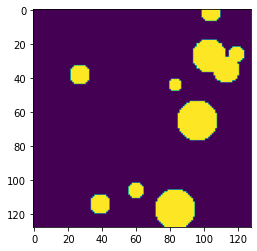

In [504]:
x = generate_big_blobs(num_blobs=10, img_size=128, avg_size=8, random_size_range=4)
plt.imshow(x)